## 전이 학습 방식의 따개비 유무 사진 분류 (Transfer Learning)

In [ ]:
%pip install opencv-python #이미지 데이터 사용할 때 opencv를 많이 사용한다

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install tqdm

In [ ]:
%pip install seaborn

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%matplotlib inline 

### 텐서플로와 다른 라이브러리 임포트

In [ ]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

import os, cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


#### GPU 메모리 설정 (프로그램에서 필요한만큼만 할당하는 방식)

In [ ]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### clean, dirty 데이터셋 로드

Zip파일 경로

In [ ]:
PATH = '/content/drive/My Drive/dataone/clean_vs_dirty'

train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

Zip파일 형태로 읽어서 zip 파일이 *있는* 디렉토리에 압축을 풀어서 사용

In [ ]:
import zipfile
import os
EXTRACT_FOLDER = os.getcwd()
TRAIN_FOLDER = os.path.join(EXTRACT_FOLDER, "train")
TEST_FOLDER =  os.path.join(EXTRACT_FOLDER, "test")

# Train 이미지
if os.path.exists(TRAIN_FOLDER) is False:
  with zipfile.ZipFile(train_image_path,"r") as z:
      z.extractall(EXTRACT_FOLDER)

# Test 이미지
if os.path.exists(TEST_FOLDER) is False:
  with zipfile.ZipFile(test_image_path,"r") as z:
      z.extractall(EXTRACT_FOLDER)

이미지 파일이름을 목록으로 읽기 (단, Train 이미지는 2만개만 읽음)

In [ ]:
SAMPLE_SIZE = 200
train_image_list = os.listdir(TRAIN_FOLDER)[0:SAMPLE_SIZE]
test_image_list = os.listdir(TEST_FOLDER)

#### 레이블 생성 
파일 이름이 clean으로 시작하면 0, dirty로 시작하면 1 
ex) 훈련 파일 : clean.100.jpg

In [ ]:
def make_image_label(filename):
    pet = filename.split('.')[-3]
    if pet == 'clean': return 0
    elif pet == 'dirty': return 1

이미지 파일로부터 데이터셋 생성
1. 레이블 생성
* 훈련 파일 이름 :  'clean.0.jpg'
* 테스트 파일 이름 : '101.jpg'
2. 이미지 읽기 (읽어서 크기 변환)



In [ ]:
IMG_SIZE = 160 데이터 목록 [image, label] 리스트
    for filename in

def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []  # tqdm(data_image_list):      # tqdm으로 Progress Bar 표시
        if(isTrain):
            label = make_image_label(filename)  # train label 생성
        else:
            label = filename.split('.')[0]

        path = os.path.join(DATA_FOLDER,filename)
        img = cv2.imread(path,cv2.IMREAD_COLOR)     # 이미지 읽기
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))  # 이미지 resize (160, 160)
        data_df.append([np.array(img),np.array(label)])

    shuffle(data_df)  # 데이터 섞기
    return data_df

##### 클래스 분포 확인

In [ ]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3]) # clean과 dirty 분리
    sns.countplot(labels)   # 같은 값의 개수를 세어서 bar 그래프로 그리기
    plt.title('Clean and Dirty')

#### 생성된 훈련 데이터셋의 클래스 분포

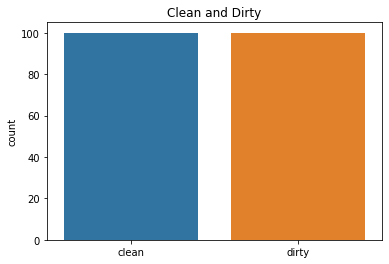

In [ ]:
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

####  훈련 이미지 폴더에 있는 이미지 파일의 클래스 분포

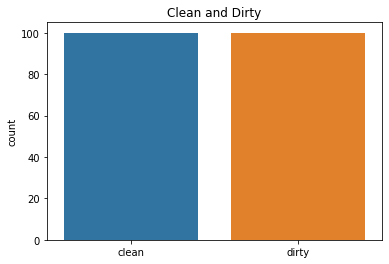

In [ ]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

#### 훈련 데이터 로드
훈련 데이터와 테스트 데이터 이미지 파일을 읽으면서 레이블 생성


In [ ]:
train = process_data(train_image_list, TRAIN_FOLDER)
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


#### 이미지를 5x5 그리드로 그리기

In [ ]:
def show_images(data, isTest=False):
    figs, ax = plt.subplots(5,5, figsize=(15,15)) # ax는 Array of axes
    for i, img in enumerate(data[:25]):
        img_data = img[0] # 이미지 데이터
        label = img[1]    # 이미지 레이블
        if label  == 1: 
            str_label='Dirty'
        elif label == 0: 
            str_label='Clean'
        if isTest:
            str_label='None'
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

#### 훈련 이미지 확인

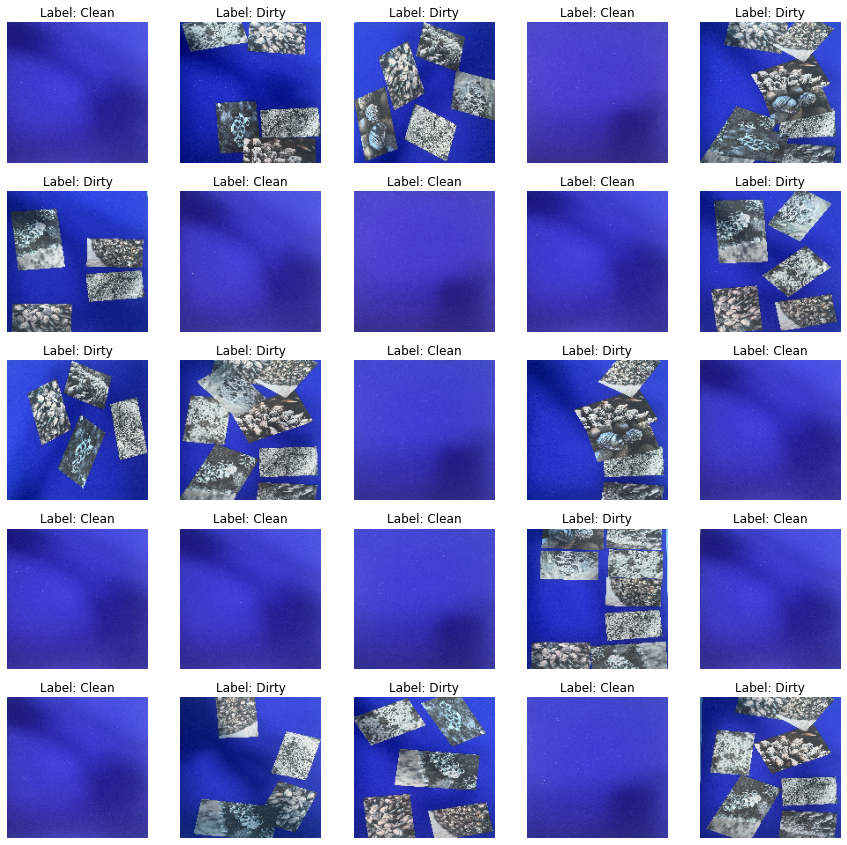

In [ ]:
show_images(train)

#### 테스트 이미지 확인

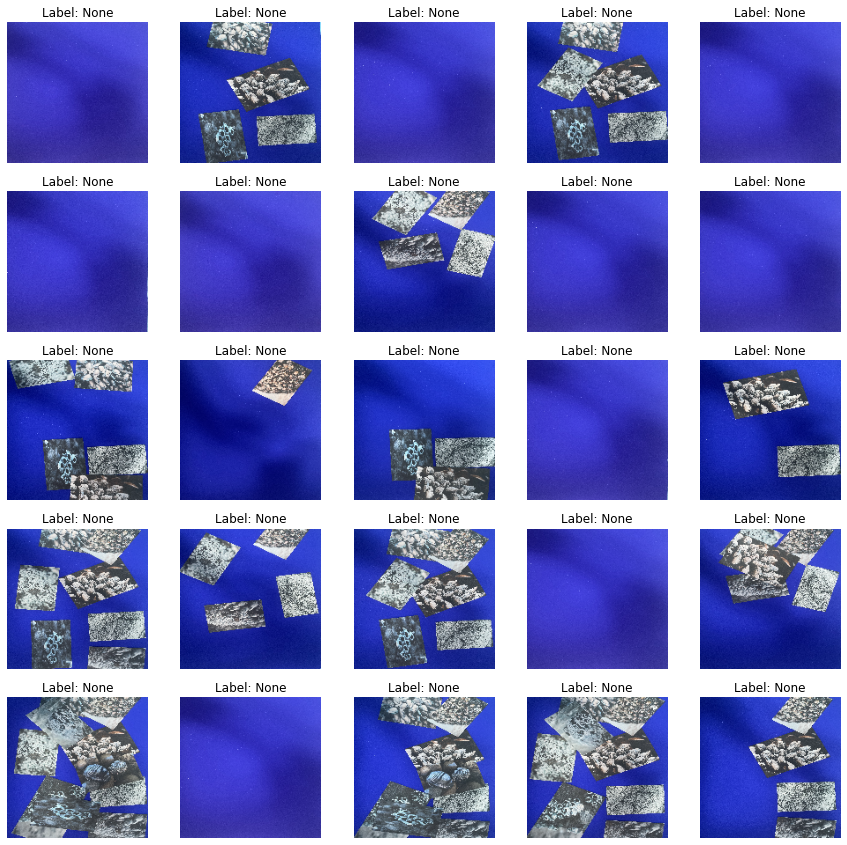

In [ ]:
show_images(test,True)

#### 훈련 데이터셋 (Numpy)

In [ ]:
train_images = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
train_labels = np.array([i[1] for i in train])

#### 테스트 데이터셋 (Numpy)

In [ ]:
test_images = np.array([i[0] for i in test])
test_labels = np.array([i[1] for i in test])

### 훈련 데이터에서 검증 데이터 분리

In [ ]:
VALIDATION_SIZE = 0.2
RANDOM_STATE = 2020
train_images, valid_images, train_labels, valid_labels = \
  train_test_split(train_images, train_labels, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

## 모델 정의

#### Pre-trained된 MobileNetV2을 기본 모델로 생성

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


모델이 학습되지 않도록 trainable을 False로 설정

In [ ]:
base_model.trainable = False
len(base_model.trainable_variables)

0

MobileNetV2 모델 확인

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

#### 모델 생성

In [ ]:
NUM_CLASSES = 2

model = keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2), 
        keras.layers.Dense(NUM_CLASSES, activation='softmax'),
        ])

len(model.trainable_variables)

2

#### 모델 구조 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### 모델 컴파일

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.Adam(lr=base_learning_rate), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### 초기 성능 확인
Fineturning하기 전 정확도가 28%대 라는 것을 확인한다.

In [ ]:
validation_steps = 20
loss0,accuracy0 = model.evaluate(valid_images, valid_labels, steps = validation_steps)

20/20 [==============================] - 0s 9ms/step - loss: 1.7531 - accuracy: 0.4750


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.75
initial accuracy: 0.47


## 모델 훈련

In [ ]:
BATCH_SIZE = 32
initial_epochs = 50

history = model.fit(train_images, train_labels,
                  epochs=initial_epochs,
                  verbose=1,
                  validation_data=(valid_images, valid_labels))

Epoch 1/50
5/5 [==============================] - 1s 274ms/step - loss: 1.5635 - accuracy: 0.5250 - val_loss: 1.4464 - val_accuracy: 0.4750
Epoch 2/50
5/5 [==============================] - 0s 55ms/step - loss: 1.3269 - accuracy: 0.5250 - val_loss: 1.1670 - val_accuracy: 0.4750
Epoch 3/50
5/5 [==============================] - 0s 55ms/step - loss: 1.0166 - accuracy: 0.5813 - val_loss: 0.9265 - val_accuracy: 0.4750
Epoch 4/50
5/5 [==============================] - 0s 58ms/step - loss: 0.8427 - accuracy: 0.6000 - val_loss: 0.7287 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 56ms/step - loss: 0.7738 - accuracy: 0.6062 - val_loss: 0.5822 - val_accuracy: 0.6500
Epoch 6/50
5/5 [==============================] - 0s 56ms/step - loss: 0.6323 - accuracy: 0.6938 - val_loss: 0.4791 - val_accuracy: 0.7750
Epoch 7/50
5/5 [==============================] - 0s 56ms/step - loss: 0.5282 - accuracy: 0.8062 - val_loss: 0.4109 - val_accuracy: 0.8750
Epoch 8/50
5/5 [==========

#### 성능 그래프

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

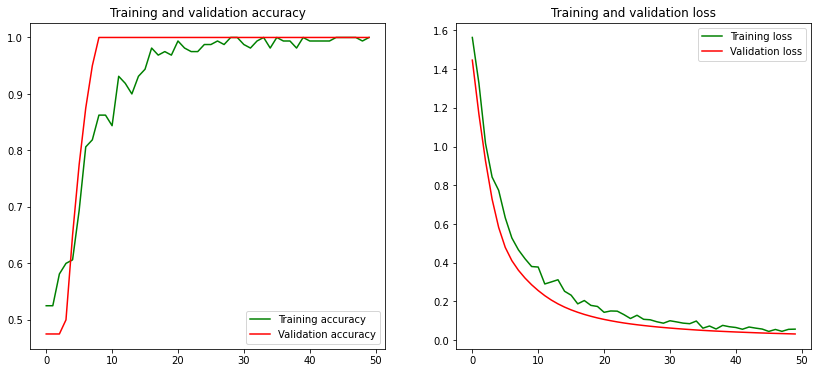

In [ ]:
plot_accuracy_and_loss(history)

### 성능 검증
Finetuning 후 정확도가 96% 이상 이라는 것을 확인한다.

In [ ]:
score = model.evaluate(valid_images, valid_labels, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.03216778486967087
Validation accuracy: 1.0


#### 클래스 별 정확도 분석

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(valid_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### 검증 데이터의 분류 성능 리포트

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(valid_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       1.00      1.00      1.00        19
    Class 1:       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



## Fine tuning

베이스 모델을 학습 가능하게 변경

In [ ]:
base_model.trainable = True
len(base_model.trainable_variables)

156

In [ ]:
len(base_model.layers)

155

100번째 계층 이후로 unfreezing

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

len(base_model.trainable_variables)

Number of layers in the base model:  155


56

#### 모델 컴파일
학습률을 1/10로 줄여서 실행

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr=base_learning_rate/10), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### 모델 구조 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

58

#### 모델 훈련

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_images, train_labels,
                         epochs=total_epochs,
                         verbose=1,
                         initial_epoch =  history.epoch[-1]+1,
                         validation_data=(valid_images, valid_labels))

Epoch 51/55
5/5 [==============================] - 1s 238ms/step - loss: 1.5892 - accuracy: 0.4938 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 52/55
5/5 [==============================] - 0s 76ms/step - loss: 1.0769 - accuracy: 0.5000 - val_loss: 0.0389 - val_accuracy: 1.0000
Epoch 53/55
5/5 [==============================] - 0s 78ms/step - loss: 0.7944 - accuracy: 0.5312 - val_loss: 0.0468 - val_accuracy: 0.9750
Epoch 54/55
5/5 [==============================] - 0s 75ms/step - loss: 0.5905 - accuracy: 0.6750 - val_loss: 0.0565 - val_accuracy: 0.9750
Epoch 55/55
5/5 [==============================] - 0s 75ms/step - loss: 0.3452 - accuracy: 0.8313 - val_loss: 0.0666 - val_accuracy: 0.9750


####  성능 확인

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy']+ history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

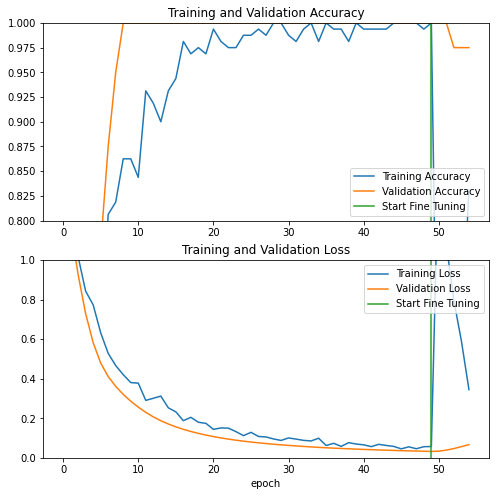

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 테스트

배열 형태로 예측 결과 확인

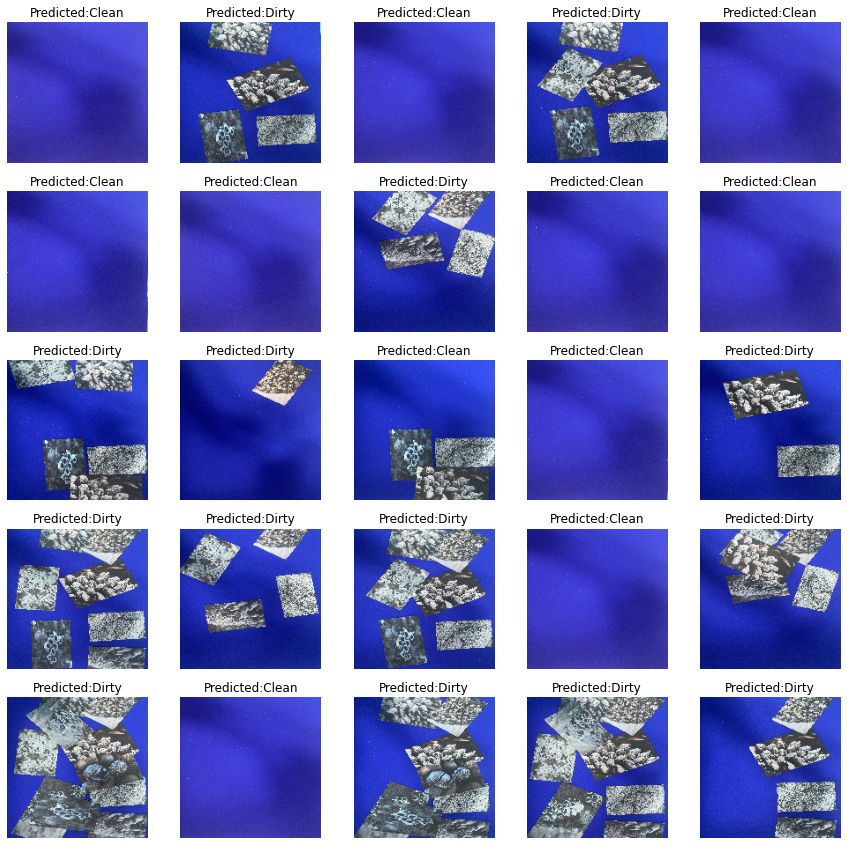

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dirty'
    else: 
        str_predicted='Clean'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()